# IA Notebook #5 - Generando flores realistas con IA Pix2Pix
Usando la libreria Tensorflow 2.1.0 y algunas librerías más que se verán conforme se va avanzando.
Lo que se hará es diseñar el modelo de IA Pix2Pix para entrenarla con imágenes borrosas de flores para que aprenda a reconstruirlas. El modelo no se limitará a solo eso, las aplicaciones pueden ser varias incluso sin variar el propio modelo, solo variando el dataset de entrenamiento.

### Nota importante
Se han removido algunas fotos que podrían perjudicar el entrenamiento, por lo que no se han cargado los checkpoints del primer entrenamiento, eso y que son muy pesados como para subirlo a GitHub. Así que todos los archivos, las fotos de las flores, los checkpoints y algunos otros varios, serán subidos a una carpeta Drive que estaré compartiendo por medio de un enlace en el Readme principal de este repositorio.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Ruta de la carpeta que contiene tanto a los datos de entrada como lo que esperamos obtener:
path = "./Recursos" # EL punto fue necesario, indica la carpeta en la que se encuentra este archivo.

# Ruta de datos de entrada:
inpath = path + "/IA_Notebook_5_input"
# Ruta de datos de salida:
outpath = path + "/IA_Notebook_5_target"
# Ruta de los checkpoints, necesarios para tener puntos de guardado del avance que tengamos con el entrenamiento de la IA:
ckpath = path + "/IA_Notebook_5_checkpoints"

# El comando "ls" (parece que) devuelve, el nombre o etiquetas de todos los archivos presentes en la dirección especificada (directorio)
# Y al darle el parámetro "-1", le decimos que nos lo acomode en una columna todos los datos, en vez de recibirlos como una lista.
# Porque en una lista, los datos están acomodados, uno por cada columna. PERO, no sé si eso afecta solo al momento de imprimir la variable o
# afecta también al almacenarlo en una variable:
imgurls = !dir /b "{inpath}" # Como estoy trabajando con windows, el comando equivalente a 'ls' es 'dir'.
# Comando "(tipo) bash", por eso va entre llaves. (https://www.tiendalinux.com/docs/manuales/redhat/rhl-gsg-es-7.1/ch-doslinux.html)

#print(type(imgurls))
#print(imgurls) # Solo es para comprobar de que se guardó como debe. (Video 17:28)

n = 500 # Se crea está variable para definir más adelante, que trabajaré solo con 500 imágenes.
train_n = round(n*0.8) # Y aquí especifíco que serán el 80% de esa cantidad, redondeandolo a un número entero.
# Ya que obviamente, no puedo procesaro solo media imagen.

# Aquí vamos a randomizar la lista de fotos antes de escoger las 500:
randurls = np.copy(imgurls)
#randurls = randurls[:, np.newaxis] # Esto solo fue un intento de corregir algún error. Se puede descartar.

np.random.seed(23) #Importante, esto es solo por el tutorial y así trabar con las mismas imágenes.
# La seed es la semilla de la aleatoriedad, si todos trabajamos con la misma semilla, obtendremos el mismo resultado aleatorio.
np.random.shuffle(randurls) #Este es el método que ya hace toda la mezcla randomizada.

# Ahora si, ya todo mezclado, repartimos nuestros datos tanto para el entrenamiento como para el testeo:
tr_urls = randurls[:train_n] # Desde el inicio hasta el 80% de 500
ts_urls = randurls[train_n:n] # Desde el 80% (de 500) hasta los 500, es decir, el 20% de 500

print(len(imgurls), " ", len(tr_urls), " ", len(ts_urls)) # Esto es solo para corroborar de que todo va bien. :3

8192   400   100


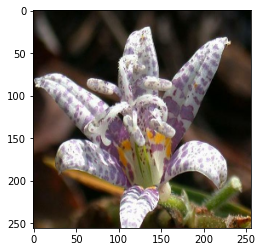

In [2]:
# Ahora se crearan algunas funciones que son necesarias para procesar las imágenes usando la libreria tensorflow.
# Haremos uso de la API "datasets", la cual nos pide que funciones queremos que le aplique a nuestros datos.
# Las funciones serán las siguiente:

IMG_ancho = 256
IMG_alto = 256

# Función para reescalar las imágenes:
def redimensionar(inImg, targetImg, anchoImg, altoImg):
    inImg = tf.image.resize(inImg, [altoImg, anchoImg])
    targetImg = tf.image.resize(targetImg, [altoImg, anchoImg])
    
    return inImg, targetImg # Retorna las dos imágenes ya redimensionadas.

# Normalizado de la imagen al rango [-1, 1], ya saben, el valor de cada pixel de la matriz que representa a la imagen:
def normalizar(inImg, targetImg):
    inImg = (inImg/127.5)-1
    targetImg = (targetImg/127.5)-1
    
    return inImg, targetImg # Retorna las dos imágenes ya normalizadas.

# Aumentación de datos: Random Crop + Flip (Recorte Aleatorio + Voltear)
# Esto permite sacar más variaciones de la misma imágen y usarlas para el entrenamiento.
@tf.function() # Este es un decorador que permite trabajar entre ambas versiones de Tensorflow, la v1 y v2. (Revisar Video 34:20)
def recorte_aleatorio(inImg, targetImg): # Originalmente se llamaba: random_jitter
    # Redimensionamos la imagen para luego hacerle recortes más pequeños desde diferentes zonas:
    inImg, targetImg = redimensionar(inImg, targetImg, 286, 286)
    
    # Con esto apilamos una imagen encima de otra pasandole ambas en una matriz y lo hará en el eje 0
    # el cual se podría entender como en el "eje x" o "eje y", lo importante es que ahora la variable "imgApilada"
    # se interpreta como un objeto tridimensional, dónde su largo y ancho son 286 y su profundidad serían las dos imágenes:
    imgApilada = tf.stack([inImg, targetImg], axis=0) # Siendo su forma: (2, 286, 286)
    # A quí ya se hacen los recortes aleatorios de DOS imágenes, con su respectiva dimensión, e indicando que son 3 canales de colores:
    imgCortada = tf.image.random_crop(imgApilada, size=[2, IMG_alto, IMG_ancho, 3])
    
    inImg, targetImg = imgCortada[0], imgCortada[1] # Con esto lo guardamos de nuevo en nuestras variables.
    
    # Esta función nos devolverá un número aleatorio pero de una distribución uniforme: (Siendo su rango por defecto: [0, 1>)
    if tf.random.uniform(()) > 0.5: # Los paréntesis son para indicarle que nos genere un escalar. (Video 34:20)
        # Y ahora se les aplicará a las dos imágenes:
        inImg = tf.image.flip_left_right(inImg)
        targetImg = tf.image.flip_left_right(targetImg)
    
    return inImg, targetImg # Retorna las dos imágenes ya alteradas.

# Función para cargar nuestras imágenes:
def cargarImg(fileName, aumentar=True): # (Video 30:56)
    # Los corchetes finales indican: "..." manten todas las dimensiones como sea que las generes
    # ":3" pero la última dimensión me la limitas a que solo tenga 3 componentes:
    inImg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(inpath+"/"+fileName)), tf.float32)[..., :3]
    targetImg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(outpath+"/"+fileName)), tf.float32)[..., :3]

    if aumentar: # Si es verdad, aplicará el recorte_aleatorio:
        inImg, targetImg = recorte_aleatorio(inImg, targetImg)

    inImg, targetImg = normalizar(inImg, targetImg)

    return inImg, targetImg # Retorna la imagen de entrada.

#Ahora, como es importante diferenciar entre una función que carga la imagen para entrenamiento y otro para pruebas, se hará:
def cargarImg_Entrenamiento(nombreArchivo):
    return cargarImg(nombreArchivo, aumentar=True)

def cargarImg_Prueba(nombreArchivo):
    return cargarImg(nombreArchivo, aumentar=False)

#Estas líneas son para poder hacer las pruebas de funcionamiento hasta dónde hemos llegado:
plt.imshow((cargarImg_Entrenamiento(randurls[8154])[1]+1)/2) # Cargo la imagen objetivo 8154 si cambio el 1 tendré la imagen de entrada.
plt.show()

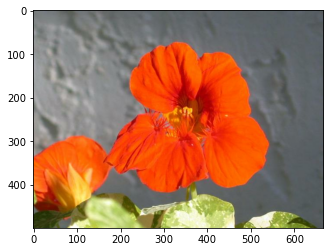

In [37]:
plt.imshow((cargarImg_Prueba(randurls[27])[1]+1)/2)
plt.show()

---
### Haciendo algunas pruebas

In [3]:
#Tensor sin dimensiones:
print(type(tf.io.read_file(inpath+"/"+"image_07739.jpg")))

#Tensor con tres dimensiones: shape=(500, 591, 3)
print(type(tf.cast(tf.image.decode_jpeg(tf.io.read_file(inpath+"/"+"image_00001.jpg")), tf.float32)[..., :3]))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [4]:
#cargarImg_Entrenamiento(randurls[0][0])
#print(tf.io.read_file(inpath+"/"+"image_07739.jpg").shape)
print(tf.cast(tf.image.decode_jpeg(tf.io.read_file(inpath+"/"+"image_00001.jpg")), tf.float32)[..., :3].shape)

(500, 591, 3)


In [5]:
randurls[0]

'image_07739.jpg'

---
### Continuando
Ahora generaremos el dataset de entrenamiento y de testeo.

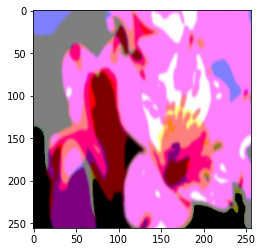

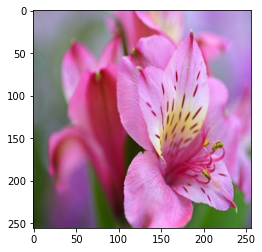

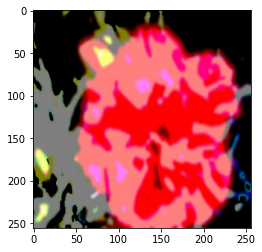

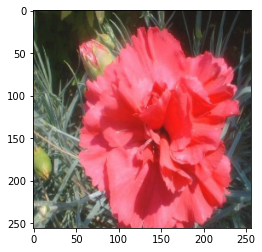

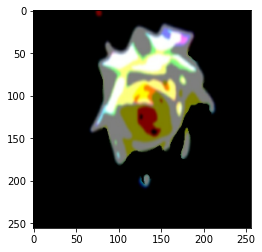

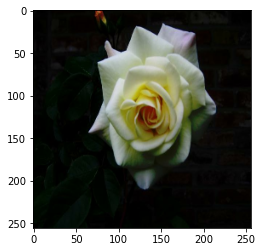

In [3]:
# Genera un dataset a partir de un listado de elementos que se le específica: (Video 43:25)
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
# Ahora cargaremos las imágenes mapaeandolas a partir del tensor (tr_urls) anterior:
train_dataset = train_dataset.map(cargarImg_Entrenamiento, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Adicionalmente, se le especifica el número de procesamientos en paralelo que van a tener las funciones al ser llamadas por "map"
# Lo normal sería usar tantos hilos como CPUs tenga el ordenador, pero se le puede decir que a tensorflow para que decida cuanto ocupar.

# Tamaño por lotes que se le va a suministrar a la red para el entrenamiento:
train_dataset = train_dataset.batch(1) # Recomiendan en el paper usar un lote de 1
# Y con esto ya estaría listo nuestro Dataset :D

# ------------------------------------------------------------------------------------------------------------
# Ahora crear el dataset del test:
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(cargarImg_Entrenamiento, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)
# ------------------------------------------------------------------------------------------------------------

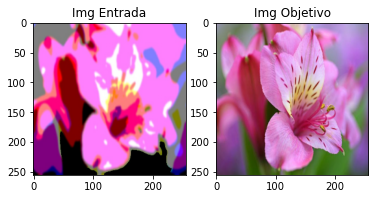

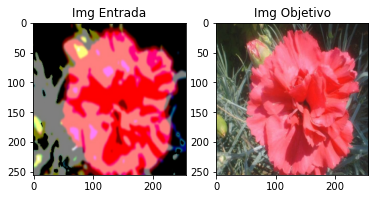

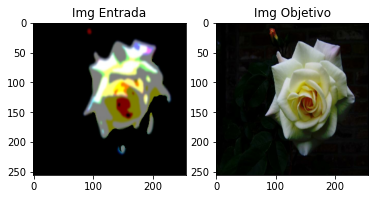

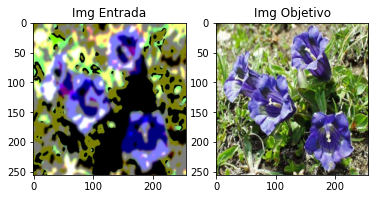

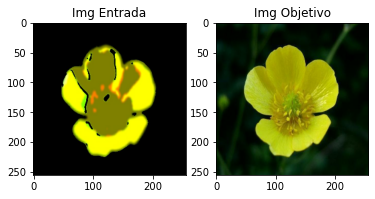

In [27]:
# Ahora a modo de prueba, mostraremos algunas imágenes:
for inIMG, tgIMG in train_dataset.take(5): # Me devuelve el número de elementos que especifique de mi dataset. En este caso: 3
    #print(tgIMG[0, 1, ...].shape) # Al ser un tensor, puedo especificar que quiero leer y que no.
    plt.subplot(1, 2, 1)
    plt.imshow((inIMG[0, ...]+1)/2)
    plt.title("Img Entrada")
    plt.subplot(1, 2, 2)
    plt.imshow((tgIMG[0, ...]+1)/2)
    plt.title("Img Objetivo")
    plt.show()

In [4]:
import tensorflow.keras as kr
import tensorflow.keras.layers as krLayer # Incluso si se importa así, se podría obviar está importación. (Video 48:42)

# Para evitar estar anteponiendo el namespace, se podría importar de la siguiente forma:
# from tensorflow.keras import *
# from tensorflow.keras.layers import *

# Como se está haciendo una compresión de la imagen (un downSample), una disminución en la resolución de la imagen, se llamará:
def reduceImg(filtros, aplicar_batchNorm=True): #También pudo ser: "reduceMuestra" pero era muy genérico.
    # Iniciando nuestro "bloque neuronal".
    
    # Iniciamos nuestro modelo y con esto le decimos a keras que lo que se va a definir es una secuencia de capas:
    res = kr.Sequential()
    
    # En el paper específica una distribución (ruido) Gaussiana con media 0 y desviación estándar de 0.02
    inicializador = tf.random_normal_initializer(0, 0.02)
    
    # Capa convolucional con dos dimensiones:
    res.add(krLayer.Conv2D(filtros, # Número de filtros de la capa convulacional. Se puede consultar: tensorflow.keras.layers.Conv2D?
                           kernel_size=4, # Indicamos el tamaño de los filtros espaciales a 4x4 (según paper).
                           strides=2, # También sacado del paper. Con esto le decimos cuantos pixeles se va a mover el filtro sobre la imagen.
                           padding="same", # Para conservar el tamaño del mapa de características según van pasando por las capas.
                           kernel_initializer=inicializador, # Indicamos que nuestros filtros se iniciaran con el "inicializador" ya declarado antes.
                           use_bias=not aplicar_batchNorm)) # ...
                           # ...Le decimos que le agregue parámetro de sesgo siempre y cuando no apliquemos el BatchNormalization.
    
    if aplicar_batchNorm:
        # Capa de Batch Normalization, Normalización (a nivel) de lotes:
        res.add(krLayer.BatchNormalization())
    
    # Capa de activación:
    res.add(krLayer.LeakyReLU())
    
    return res

# Hay que tener claro que cada cosa que se defina con esta función será un bloque usado como otra capa más que será parte del Encoder
reduceImg(64)

In [5]:
# Como se está haciendo una descompresión de la imagen (un upSample), una aumento en la resolución de la imagen, se llamará:
def aumentaImg(filtros, aplicar_dropout=False): # Lo que hace es aumentar el número de muestras... (Video 55:40)
    # ... Porque como se sabe, la imagen fue comprimida y ahora vamos a descomprimirla.
    
    res = kr.Sequential()
    
    # En el paper específica una distribución (ruido) Gaussiana con media 0 y desviación estándar de 0.02
    inicializador = tf.random_normal_initializer(0, 0.02)
    
    # Capa convolucional transpuesta con dos dimensiones:
    res.add(krLayer.Conv2DTranspose(filtros,
                                    kernel_size=4,
                                    strides=2,
                                    padding="same",
                                    kernel_initializer=inicializador,
                                    use_bias=False))
    
    # Capa de Batch Normalization, Normalización (a nivel) de lotes:
    res.add(krLayer.BatchNormalization())
    
    # Capa de dropout (soltar fuera|abandonar|o simplemente "soltar"):
    if aplicar_dropout:
        res.add(krLayer.Dropout(0.5))
    
    # Capa de activación:
    res.add(krLayer.ReLU())
    
    return res

# Hay que tener claro que cada cosa que se defina con esta función será un bloque usado como otra capa más que será parte del Decoder
aumentaImg(64)

In [6]:
# Creando el modelo generador U-Net (Video 58:33)

# Creamos esta función para instanciar todas las capas del U-Net, no para conectarlas, solo para instanciarlas:
def Generador():
    # Le específicamos que tendrá una entrada de "no sabemos cuanto"x"no sabemos cuanto"x3 lo cual serían las dimensiones de la imagen.
    # Ancho x Alto x Canales_de_Color
    entradas = krLayer.Input(shape=[None, None, 3]) #Así podemos dejar abierto a que podamos meterle una imagen de cualquier tamaño.
    
    # Creamos el Encoder:
    reduce_stack = [
        reduceImg(64, aplicar_batchNorm=False), # (bs, 128, 128, 64)
        reduceImg(128),                         # (bs, 64, 64, 128)
        reduceImg(256),                         # (bs, 32, 32, 256)
        reduceImg(512),                         # (bs, 16, 16, 512)
        reduceImg(512),                         # (bs, 8, 8, 512)
        reduceImg(512),                         # (bs, 4, 4, 512)
        reduceImg(512),                         # (bs, 2, 2, 512)
        reduceImg(512),                         # (bs, 1, 1, 512)
    ]
    
    # Creamos el Decoder:
    aumenta_stack = [
        aumentaImg(512, aplicar_dropout=True), # (bs, 2, 2, 1024)
        aumentaImg(512, aplicar_dropout=True), # (bs, 4, 4, 1024)
        aumentaImg(512, aplicar_dropout=True), # (bs, 8, 8, 1024)
        aumentaImg(512),                       # (bs, 16, 16, 1024)
        aumentaImg(256),                       # (bs, 32, 32, 512)
        aumentaImg(128),                       # (bs, 64, 64, 256)
        aumentaImg(64),                        # (bs, 128, 128, 128)
    ]
    
    inicializador = tf.random_normal_initializer(0, 0.02)
    # Capa que me va a generar la imagen:
    ultimaCapa = krLayer.Conv2DTranspose(filters=3, # El número de filtros de esta capa define el número de canales que debe tener lo que sale...
                                         # ... por lo que es necesario fijarlo en 3 para tener los tres canales de colores (RGB).
                                         kernel_size=4, # Tamaño del filtro espacial tal como dice en el paper.
                                         strides=2,
                                         padding="same",
                                         kernel_initializer=inicializador, # En el paper específica que se le dé estos valores al iniciar.
                                         activation="tanh") # Ya que nuestras imágenes vienen con un rango de -1 a 1, es que se usa "tanh".
    
    # ---------------------------------------
    x = entradas
    skCon = [] # Aquí guardaremos las skipConecction
    concatenar = krLayer.Concatenate() # Con esta función vamos a poder concatenar el resultado de dos capas, en este caso, capas diferentes.
    for redu in reduce_stack: # Conectamos todas las capas del encoder.
        x = redu(x)
        skCon.append(x) # Con esto vamos agregando cada resultado que nos vota al procesar nuestra entrada por esa capa.
        
    # Invertimos los valores para poder concatenarlas con el decoder:
    skCon = reversed(skCon[:-1]) # Invertimos todos los elementos hasta el penúltimo, el último elemento lo descartamos.
    
    for aum, skC in zip(aumenta_stack, skCon): # Conectamos todas las capas del decoder.
        x = aum(x)
        x = concatenar([x, skC])
    # Con estos dos bucle for hemos podido conectar cada una de las capas del encoder al decoder. (Las skipconnections)
    
    ultimaCapa = ultimaCapa(x)
    
    return kr.Model(inputs=entradas, outputs=ultimaCapa)
# Finalmente con esta función, hemos podido crear el modelo U-Net

---
### Pruebas

In [57]:
#Esto no es totalmente necesario de hacer, es solo una prueba:
print(train_dataset.take(1))
print(train_dataset.take(2))
#Antes de probar el generador inicializaremos una variable con una imagen:
imgPrueba1, imgPrueba2 = train_dataset.take(2) # Por alguna razón, se guarda mejor cuando recojo en dos variables.

<TakeDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>
<TakeDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>


(256, 256, 3)


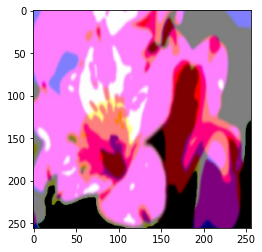

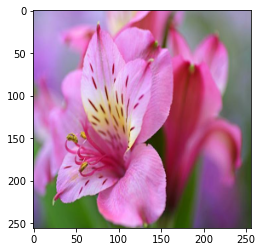

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Y este es el resultado que por ahora da nuestro modelo U-Net:


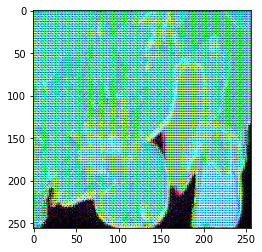

In [69]:
print(imgPrueba1[0][0, ...].shape)
#Probando el generador:
g = Generador()
g_salida = g(((imgPrueba1[0]+1)*255), training=False)
plt.imshow(((imgPrueba1[0][0, ...]+1)/2))
plt.show()
plt.imshow(((imgPrueba1[1][0, ...]+1)/2))
plt.show()
print("Y este es el resultado que por ahora da nuestro modelo U-Net:")
plt.imshow(g_salida[0, ...])
plt.show()

---

In [7]:
#Creamos la función que instancie al Discriminador: (Video 1:18:00)
def Discriminador():
    ini = krLayer.Input(shape=[None, None, 3], name="entrada_img")
    gen = krLayer.Input(shape=[None, None, 3], name="generada_img")
    
    conca = krLayer.concatenate([ini, gen])
    
    inicializador = tf.random_normal_initializer(0, 0.02)
    
    down1 = reduceImg(64, aplicar_batchNorm=False)(conca)
    down2 = reduceImg(128)(down1)
    down3 = reduceImg(256)(down2)
    down4 = reduceImg(512)(down3)
    
    ultimaCapa = krLayer.Conv2D(filters=1, # Es suficiente un solo canal de información.
                                kernel_size=4,
                                strides=1,
                                padding="same",
                                kernel_initializer=inicializador)(down4)
    
    return kr.Model(inputs=[ini, gen], outputs=ultimaCapa)

---
### Practicando

In [75]:
#Esto no es totalmente necesario de hacer, es solo una prueba:
discri = Discriminador()

dis_salida = discri([((imgPrueba1[0]+1)*255), g_salida], training=False)
dis_salida.shape

TensorShape([1, 16, 16, 1])

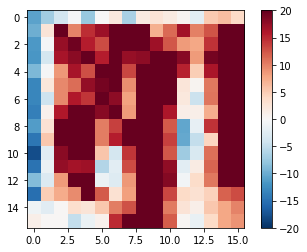

In [76]:
plt.imshow(dis_salida[0, ..., -1], vmin=-20, vmax=20, cmap="RdBu_r")
plt.colorbar()
plt.show()

---
## Declaramos generador y discriminador

In [8]:
# Antes de continuar, declaramos las siguientes funciones:
generador = Generador()
discriminador = Discriminador()

#Ahora si, continuando...

In [9]:
# Definimos un objeto de coste usando la función "BinaryCrossentropy" de Keras: (calcula la entropía cruzada de cada pixel de cada imagen generada)
coste_objeto = kr.losses.BinaryCrossentropy(from_logits=True) # Con "from_logits" en True, nos normaliza las imágenes de entrada aplicandole una función sigmoide y así acotarla entre 0 y 1

# Ahora definimos una función que nos discrime el coste: (Video 1:21:33)
def discrimador_Coste(disc_RealOut, disc_GenOut):
    # Diferencia entre los True por ser real y el detectado por el discriminador:
    real_coste = coste_objeto(tf.ones_like(disc_RealOut), disc_RealOut)
    
    #Diferencia entre los False por ser generado y el detectado por el discriminador:
    generado_coste = coste_objeto(tf.zeros_like(disc_GenOut), disc_GenOut)
    
    coste_total_disc = real_coste + generado_coste
    
    return coste_total_disc

LAMBDA = 100 # Hiperparámetro que dará mayor o menos peso a la "Media de error absoluto". Según paper, este es el valor óptimo.
# Definimos de manera similar, otra función pero del coste generado por el Generador:
def generador_Coste(disc_generador_salida, gen_salida, objetivo):
    gan_coste = coste_objeto(tf.ones_like(disc_generador_salida), disc_generador_salida)
    
    # Media de error absoluto:
    coste_medio = tf.reduce_mean(tf.abs(objetivo - gen_salida))
    # Este es la diferencia por pixel en valor absoluto entre la imagen que queriamos generar y la que hemos generado.
    
    coste_total_gen = gan_coste + (LAMBDA * coste_medio) #Aquí le estamos dando más peso al coste_medio.
    
    return coste_total_gen

---
## Celdas adicionales Importantes
Estás celdas que se muestran a continuación, no son parte de la creación de nuestro modelo, pero si para cuando lo entremos:

In [10]:
# Ver video en 1:27:12
import os

# Los valores y funciones utilizadas, están indicadas en el paper:
optimizar_generador = kr.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999) # Personalmente saqué el beta_2 del paper, en el video no lo ponen.
optimizar_discriminador = kr.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999) # Aunque en la página de referencia, tampoco lo usan.
# Página de referencia: https://www.tensorflow.org/tutorials/generative/pix2pix

checkpoint_prefix = os.path.join(ckpath, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=optimizar_generador,
                                 discriminator_optimizer=optimizar_discriminador,
                                 generator=generador,
                                 discriminator=discriminador)

# Para restaurar al checkpoint se usa:
#checkpoint.restore(tf.train.latest_checkpoint(ckpath)).assert_consumed()

In [32]:
# Ver video en 1:28:33
def generar_imagenes(modelo, entrada_prueba, objetivo, guardar_nombreArchivo=False, mostrarImagen=True, entrenando=True):
    if entrenando:
        prediccion = modelo(entrada_prueba, training=True)
    else:
        prediccion = modelo(entrada_prueba, training=False)
    
    if guardar_nombreArchivo:
        kr.preprocessing.image.save_img(path + "/IA_Notebook_5_output/" + guardar_nombreArchivo + ".png", prediccion[0, ...])
    
    plt.figure(figsize=(10, 10))
    
    mostrar_listaImg = [entrada_prueba[0], objetivo[0], prediccion[0]]
    titulo = ["Imagen de Entrada", "Imagen Real", "Imagen Generada"]
    
    if mostrarImagen:
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(titulo[i])
            # No olvidar que el valor de los pixeles es entre [0, 1] para ser gráficados.
            plt.imshow(mostrar_listaImg[i]*0.5 + 0.5)
            plt.axis("off")
    
    plt.show()

In [29]:
# Pequeña Prueba:
def unafun(cadena=True):
    if cadena:
        print(cadena + "xD")

unafun("espera...") # Si funcionó!! xD

espera...xD


In [12]:
# Ver video en 1:30:49 | No es un error, está función la crea después de la siguiente. xD
@tf.function() # Lo recomienda poner para agilizar el proceso, desconozco el motivo.
def entrenar_Paso(inImagen, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
        outImagen = generador(inImagen, training=True)
        out_gen_discrimina = discriminador([outImagen, inImagen], training=True)
        out_target_discrimina = discriminador([target, inImagen], training=True)
        discr_coste = discrimador_Coste(out_target_discrimina, out_gen_discrimina)
        gen_coste = generador_Coste(out_gen_discrimina, outImagen, target)
        
        # Calcula las gradientes para cada función: (Descenso del Gradiente)
        gradiente_Gen = gen_tape.gradient(gen_coste, generador.trainable_variables)
        gradiente_Disc = discr_tape.gradient(discr_coste, discriminador.trainable_variables)
        
        # Ahora llamamos a los optimizadores antes declarados: (Adam)
        optimizar_generador.apply_gradients(zip(gradiente_Gen, generador.trainable_variables))
        optimizar_discriminador.apply_gradients(zip(gradiente_Disc, discriminador.trainable_variables))

In [13]:
# Ver video en 1:29:14
from IPython.display import clear_output

def entrenar(dataset, num_epocas):
    for epoca in range(num_epocas):
        imagen = 0
        for imgEntrada, objetivo in dataset:
            print("Época " + str(epoca) + " - entrena: " + str(imagen) + "/" + str(len(tr_urls)))
            imagen+=1
            entrenar_Paso(imgEntrada, objetivo) # Aún no defino esta función.
            clear_output(wait=True) # Lo incluye en el 'for' para que no se acumule, ya que será un proceso muy largo.
        
        #clear_output(wait=True)
        imagen = 0
        for inp, targ in test_dataset.take(5): # Probamos al modelo después de cada entrenamiento con el dataset de Pruebas.
            generar_imagenes(generador, inp, targ, str(imagen) + "_" + str(epoca), mostrarImagen=True)
            imagen+=1
        
        # Guardamos (hacemos checkpoint) el modelo cada 25 épocas:
        if (epoca + 1) % 25 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

---

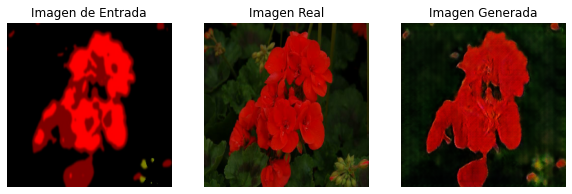

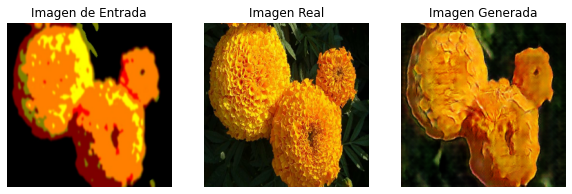

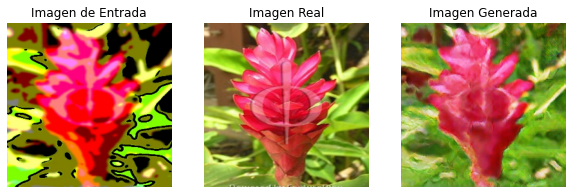

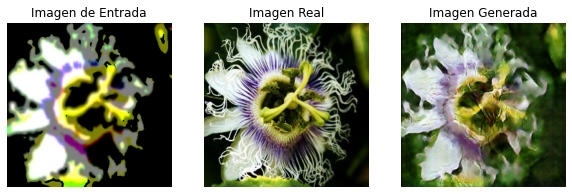

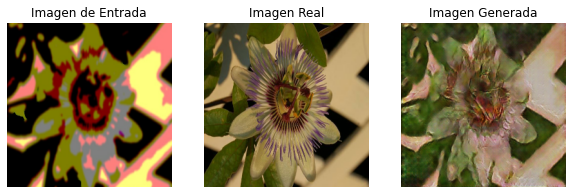

In [16]:
# Primer entrenamiento:
entrenar(train_dataset, 100)

In [14]:
# Comproban que tengamos PIL instalado:
from PIL import Image
print(Image.__file__)

C:\Users\Moises\anaconda3\envs\IA_ML_2_0\lib\site-packages\PIL\Image.py


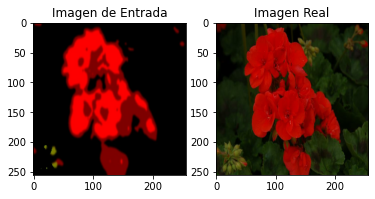

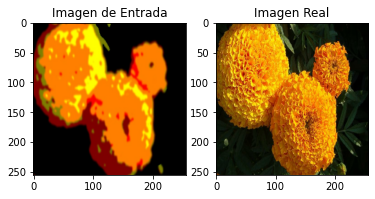

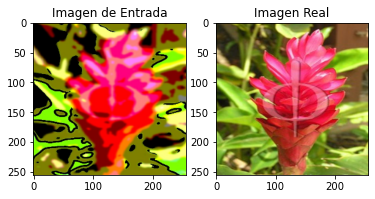

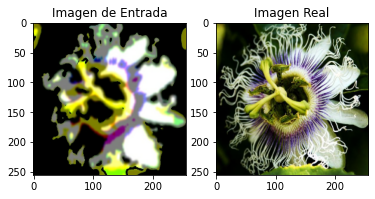

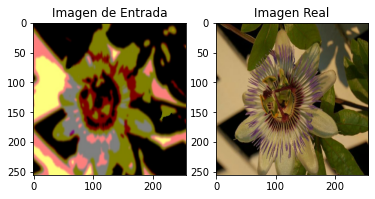

In [23]:
titulo = ["Imagen de Entrada", "Imagen Real"]
for inp, targ in test_dataset.take(5):
    plt.subplot(1, 2, 1)
    plt.title(titulo[0])
    plt.imshow((inp[0, ...]+1)/2)
    plt.subplot(1, 2, 2)
    plt.title(titulo[1])
    plt.imshow((targ[0, ...]+1)/2)
    plt.show()

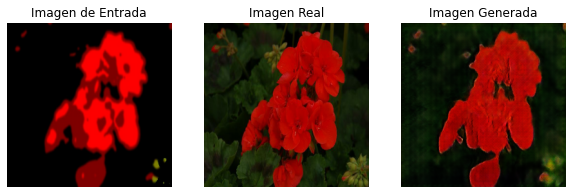

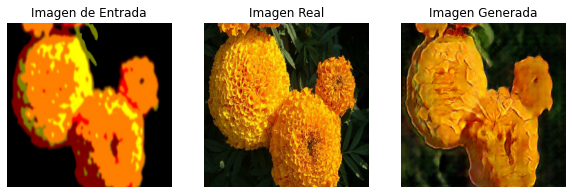

In [68]:
imagen = 0
for inp, targ in test_dataset.take(2):
    generar_imagenes(generador, inp, targ, "Prediccion_" + str(imagen), mostrarImagen=True, entrenando=True)
    # Investigar porque tiene que seguir en "entrenando" si ahora ya solo quiero probar el modelo.
    imagen+=1

#cargarImg_Prueba(randurls[27])[0][tf.newaxis, ...].shape
#imE = imE[tf.newaxis, ...]
#generar_imagenes(generador, cargarImg_Prueba(randurls[27])[0][tf.newaxis, ...], cargarImg_Prueba(randurls[27])[1][tf.newaxis, ...], "Prediccion_Controlada", mostrarImagen=True, entrenando=True)
#plt.imshow((cargarImg_Prueba(randurls[27])[1]+1)/2)
#plt.show()

In [62]:
print(tf.data.Dataset.range(10).take(1))
print(test_dataset.take(1))
print(test_dataset.take(2))

<TakeDataset shapes: (), types: tf.int64>
<TakeDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>
<TakeDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>


In [ ]:
# Para restaurar al último checkpoint se usa:
#checkpoint.restore(tf.train.latest_checkpoint(ckpath)).assert_consumed() # El último checkpoint fue de 100 épocas.

In [ ]:
# Segundo entrenamiento:
entrenar(train_dataset, 100)